In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
# 그래프를 그리기 위한 matplotlib 및 기타 utility 라이브러리를 import함
import pickle
import pandas as pd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
import joblib

In [2]:
from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화에 사용할 MinMaxScaler import
from sklearn.metrics import mean_squared_error  # MSE 성능 지표를 계산하기 하기 위한 함수 import

# 모델을 구축하기 위한 keras 관련 함수 import
from tensorflow.keras.models import *
from tensorflow.keras.layers import Lambda, RepeatVector
from tensorflow.keras.layers import Input, multiply
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import regularizers
import keras.backend as K
from keras.callbacks import EarlyStopping

## 평가지표 : SMAPE 

In [3]:
def Symmetric_mean_absolute_percentage_error(actual, predicted):
    
    total=len(actual)
    numerator=np.abs(actual-predicted)
    denominator=np.abs(actual)+np.abs(predicted)
    SMAPE=(100/total)*np.sum(numerator/denominator)
    
    return SMAPE

## LSTM모델 정의

In [4]:
def lstm_model(batch_size, time_step, feature_num):
        """LSTM 모델 정의"""
        inputs = Input(shape=(time_step, feature_num))
        x = LSTM(6, activation='tanh',
        stateful=False,
        return_sequences=True,
        kernel_initializer='he_normal')(inputs)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(10, activation='linear', kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l1(0.))(x)
        output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)

        model = Model(inputs=[inputs], outputs=output)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        return model,early_stopping

In [5]:
# 하이퍼 파라미터 정의
batch_size = 4
time_steps = 24
feature_num = 4

In [6]:
# LSTM 모델을 생성하고 compile를 진행함
model,early_stopping=lstm_model(batch_size, time_steps, feature_num)
model.compile(loss='mean_squared_error', optimizer='adam')

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                            patience=10,         # 10회 Epoch동안 개선되지 않는다면 종료
                            )

## LSTM모델에 입력할 형태로 데이터 변환하기

In [7]:
def data_transform(name,time_steps):
    data=pd.read_csv("../Merged_Data/{:s}.csv".format(name))
    
    print("column =",data.columns)
    
    if name.split("x")[-1]=='(Seasonal_Trend)':
        
        data=data.drop("time",axis=1)
        sequences=[]
        for i in range(len(data) - time_steps + 1):
            sequence = data[i:i+time_steps]
            sequences.append(sequence)
        return np.array(sequences)
    
    return np.array(data[23:])

In [8]:
train_x=data_transform('train_x(Seasonal_Trend)',24)
train_y=data_transform('train_y',24)
test_x=data_transform('test_x(Seasonal_Trend)',24)
test_y=data_transform('test_y',24)
valid_x=data_transform('valid_x(Seasonal_Trend)',24)
valid_y=data_transform('valid_y',24)

column = Index(['time', 'in_pm10_min', 'in_pm10_max', 'in_voc_min',
       'in_pm10_Seasonal_Trend'],
      dtype='object')
column = Index(['Y_pm10'], dtype='object')
column = Index(['time', 'in_pm10_min', 'in_pm10_max', 'in_voc_min',
       'in_pm10_Seasonal_Trend'],
      dtype='object')
column = Index(['Y_pm10'], dtype='object')
column = Index(['time', 'in_pm10_min', 'in_pm10_max', 'in_voc_min',
       'in_pm10_Seasonal_Trend'],
      dtype='object')
column = Index(['Y_pm10'], dtype='object')


In [9]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)

(55204, 24, 4)
(55204, 1)
(3045, 24, 4)


## 모델 훈련(epoch=100)

In [10]:
# 모델 훈련 진행
# 훈련 과정의 손실값을 history 변수에 저장
history = model.fit(train_x, train_y,
                    validation_data=(valid_x, valid_y),
                    batch_size=batch_size, epochs=100,
                    callbacks=[earlystopping],)

Epoch 1/100
13801/13801 [==============================] - 37s 3ms/step - loss: 0.0114 - val_loss: 0.0035
Epoch 2/100
13801/13801 [==============================] - 36s 3ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 3/100
13801/13801 [==============================] - 36s 3ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 4/100
13801/13801 [==============================] - 36s 3ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 5/100
13801/13801 [==============================] - 37s 3ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/100
13801/13801 [==============================] - 37s 3ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 7/100
13801/13801 [==============================] - 36s 3ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 8/100
13801/13801 [==============================] - 36s 3ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/100
13801/13801 [==============================] - 36s 3ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 10/100
13801/13801 [====================

## 모델 불러오기, 결과확인

In [15]:
from tensorflow.python.keras.models import load_model

if not os.path.exists("./Saved_Model(Seasonal_Trend)/"):
    os.makedirs("./Saved_Model(Seasonal_Trend)/")

model.save('./Saved_Model(Seasonal_Trend)/LSTM(Early_Stopping).pt')

INFO:tensorflow:Assets written to: ./Saved_Model(Seasonal_Trend)/LSTM(Early_Stopping).pt\assets


INFO:tensorflow:Assets written to: ./Saved_Model(Seasonal_Trend)/LSTM(Early_Stopping).pt\assets


In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

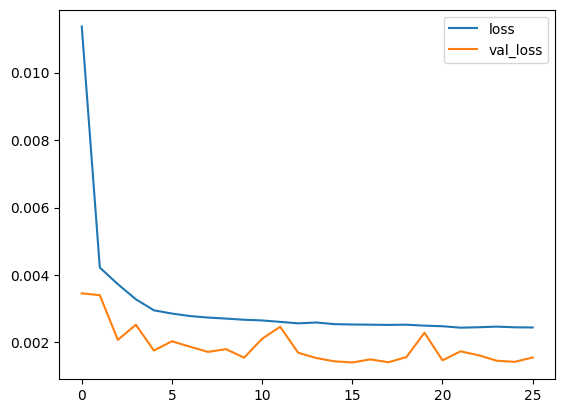

In [17]:
# train loss와 validation loss의 변화를 matplotlib를 사용해 시각화함
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()

In [18]:
from tensorflow.python.keras.models import load_model
LSTM_model=load_model('./Saved_Model(Seasonal_Trend)/LSTM(Early_Stopping).pt')

train_predict = LSTM_model.predict(train_x, batch_size)
valid_predict = LSTM_model.predict(valid_x, batch_size)
test_predict = LSTM_model.predict(test_x, batch_size)

In [19]:
import joblib
scaler=joblib.load('../Merged_Data/Scaler/Y_pm10.pkl')
inv_train_y = scaler.inverse_transform(train_y)
inv_train_predict = scaler.inverse_transform(train_predict)
inv_valid_y = scaler.inverse_transform(valid_y)
inv_valid_predict = scaler.inverse_transform(valid_predict)
inv_test_y = scaler.inverse_transform(test_y)
inv_test_predict = scaler.inverse_transform(test_predict)

In [20]:
train_smape = Symmetric_mean_absolute_percentage_error(inv_train_y, inv_train_predict)
valid_smape = Symmetric_mean_absolute_percentage_error(inv_valid_y, inv_valid_predict)
test_smape = Symmetric_mean_absolute_percentage_error(inv_test_y, inv_test_predict)

In [21]:
print("Train SMAPE :" ,train_smape)
print("Valid SMAPE :" ,valid_smape)
print("Test SMAPE :" ,test_smape)

Train SMAPE : 9.724322141333417
Valid SMAPE : 14.559498688761652
Test SMAPE : 6.353339655599074


## 결과 시각화

In [22]:
def vizualization_self(train_term,name,test_y,pred_y):
    plt.figure(figsize=(32, 16))
    
    plt.plot(np.arange(train_term), test_y[:train_term], color='red', ls='-', lw=3, label='Raw Data')
    plt.plot(np.arange(train_term), pred_y[:train_term], color='blue', ls='--', lw=3, label='Prediction')
    
    plt.xlabel('[Time]', fontsize=25, fontweight='bold')
    plt.ylabel('[PM10]', fontsize=25, fontweight='bold')
    plt.title('Prediction Visualization({:s})'.format(name),fontsize=30, weight='bold')
    plt.xticks( fontsize=15, fontweight='bold')
    plt.yticks( fontsize=15, fontweight='bold')
    plt.grid(True)
    plt.legend()
    return

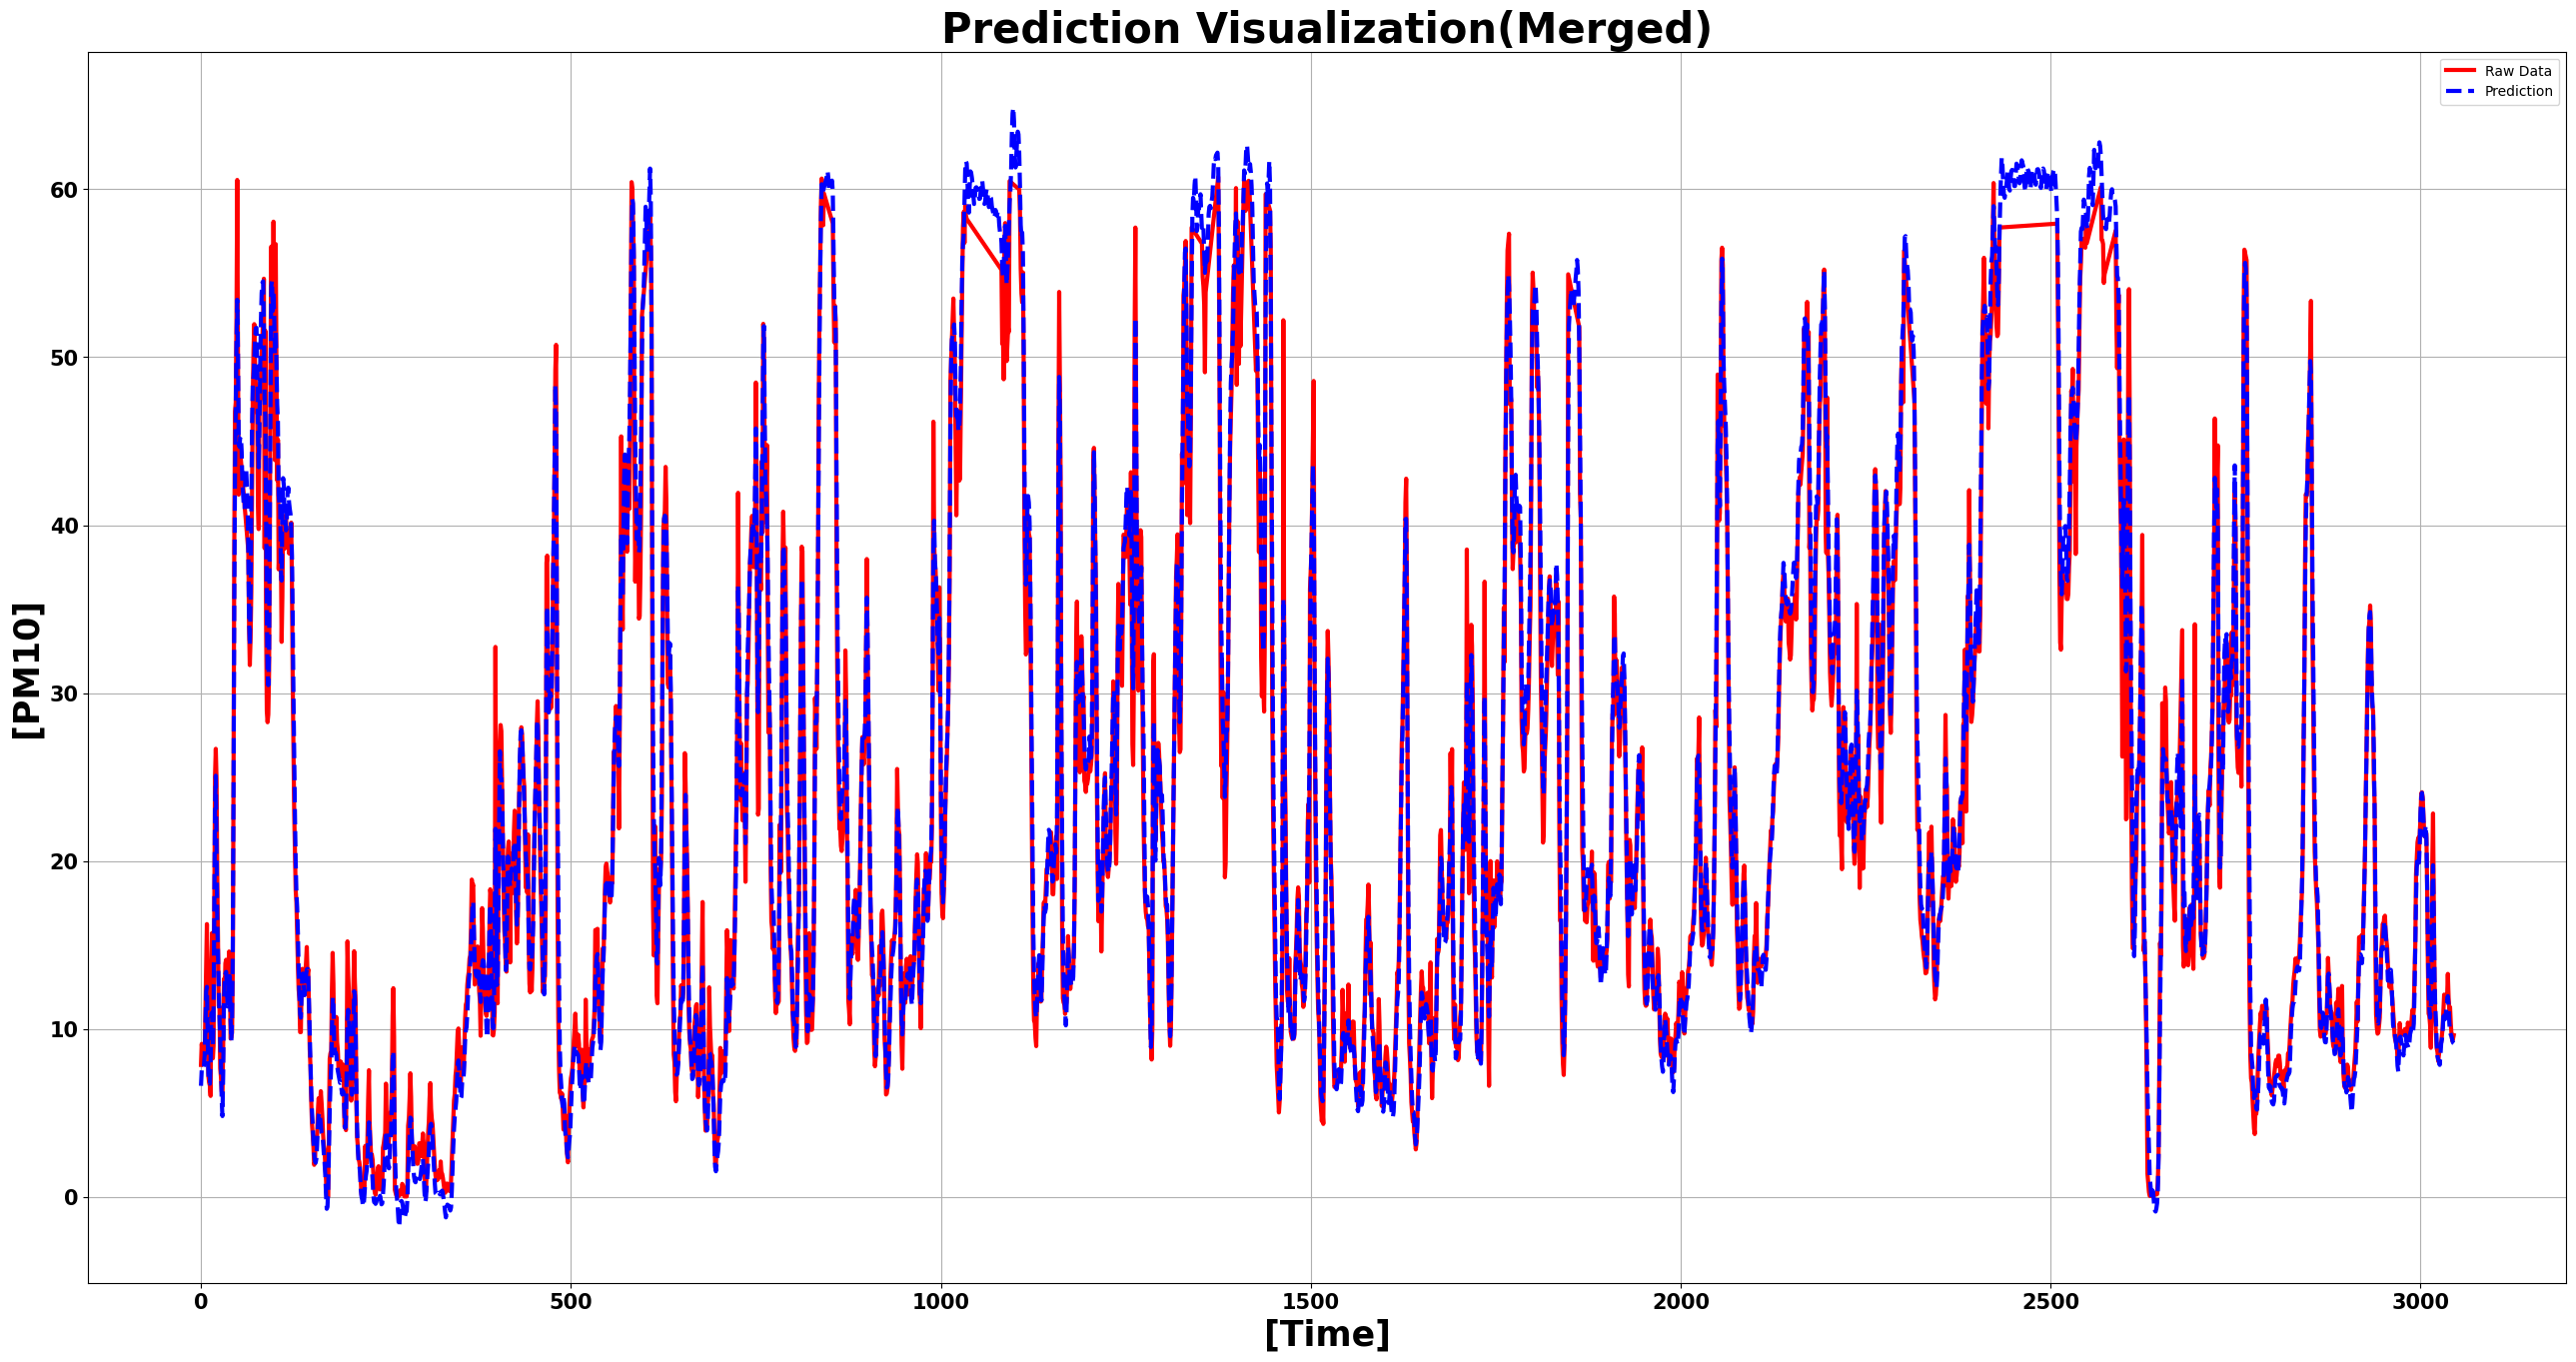

In [26]:
vizualization_self(len(inv_test_y),'Merged',inv_test_y,inv_test_predict)

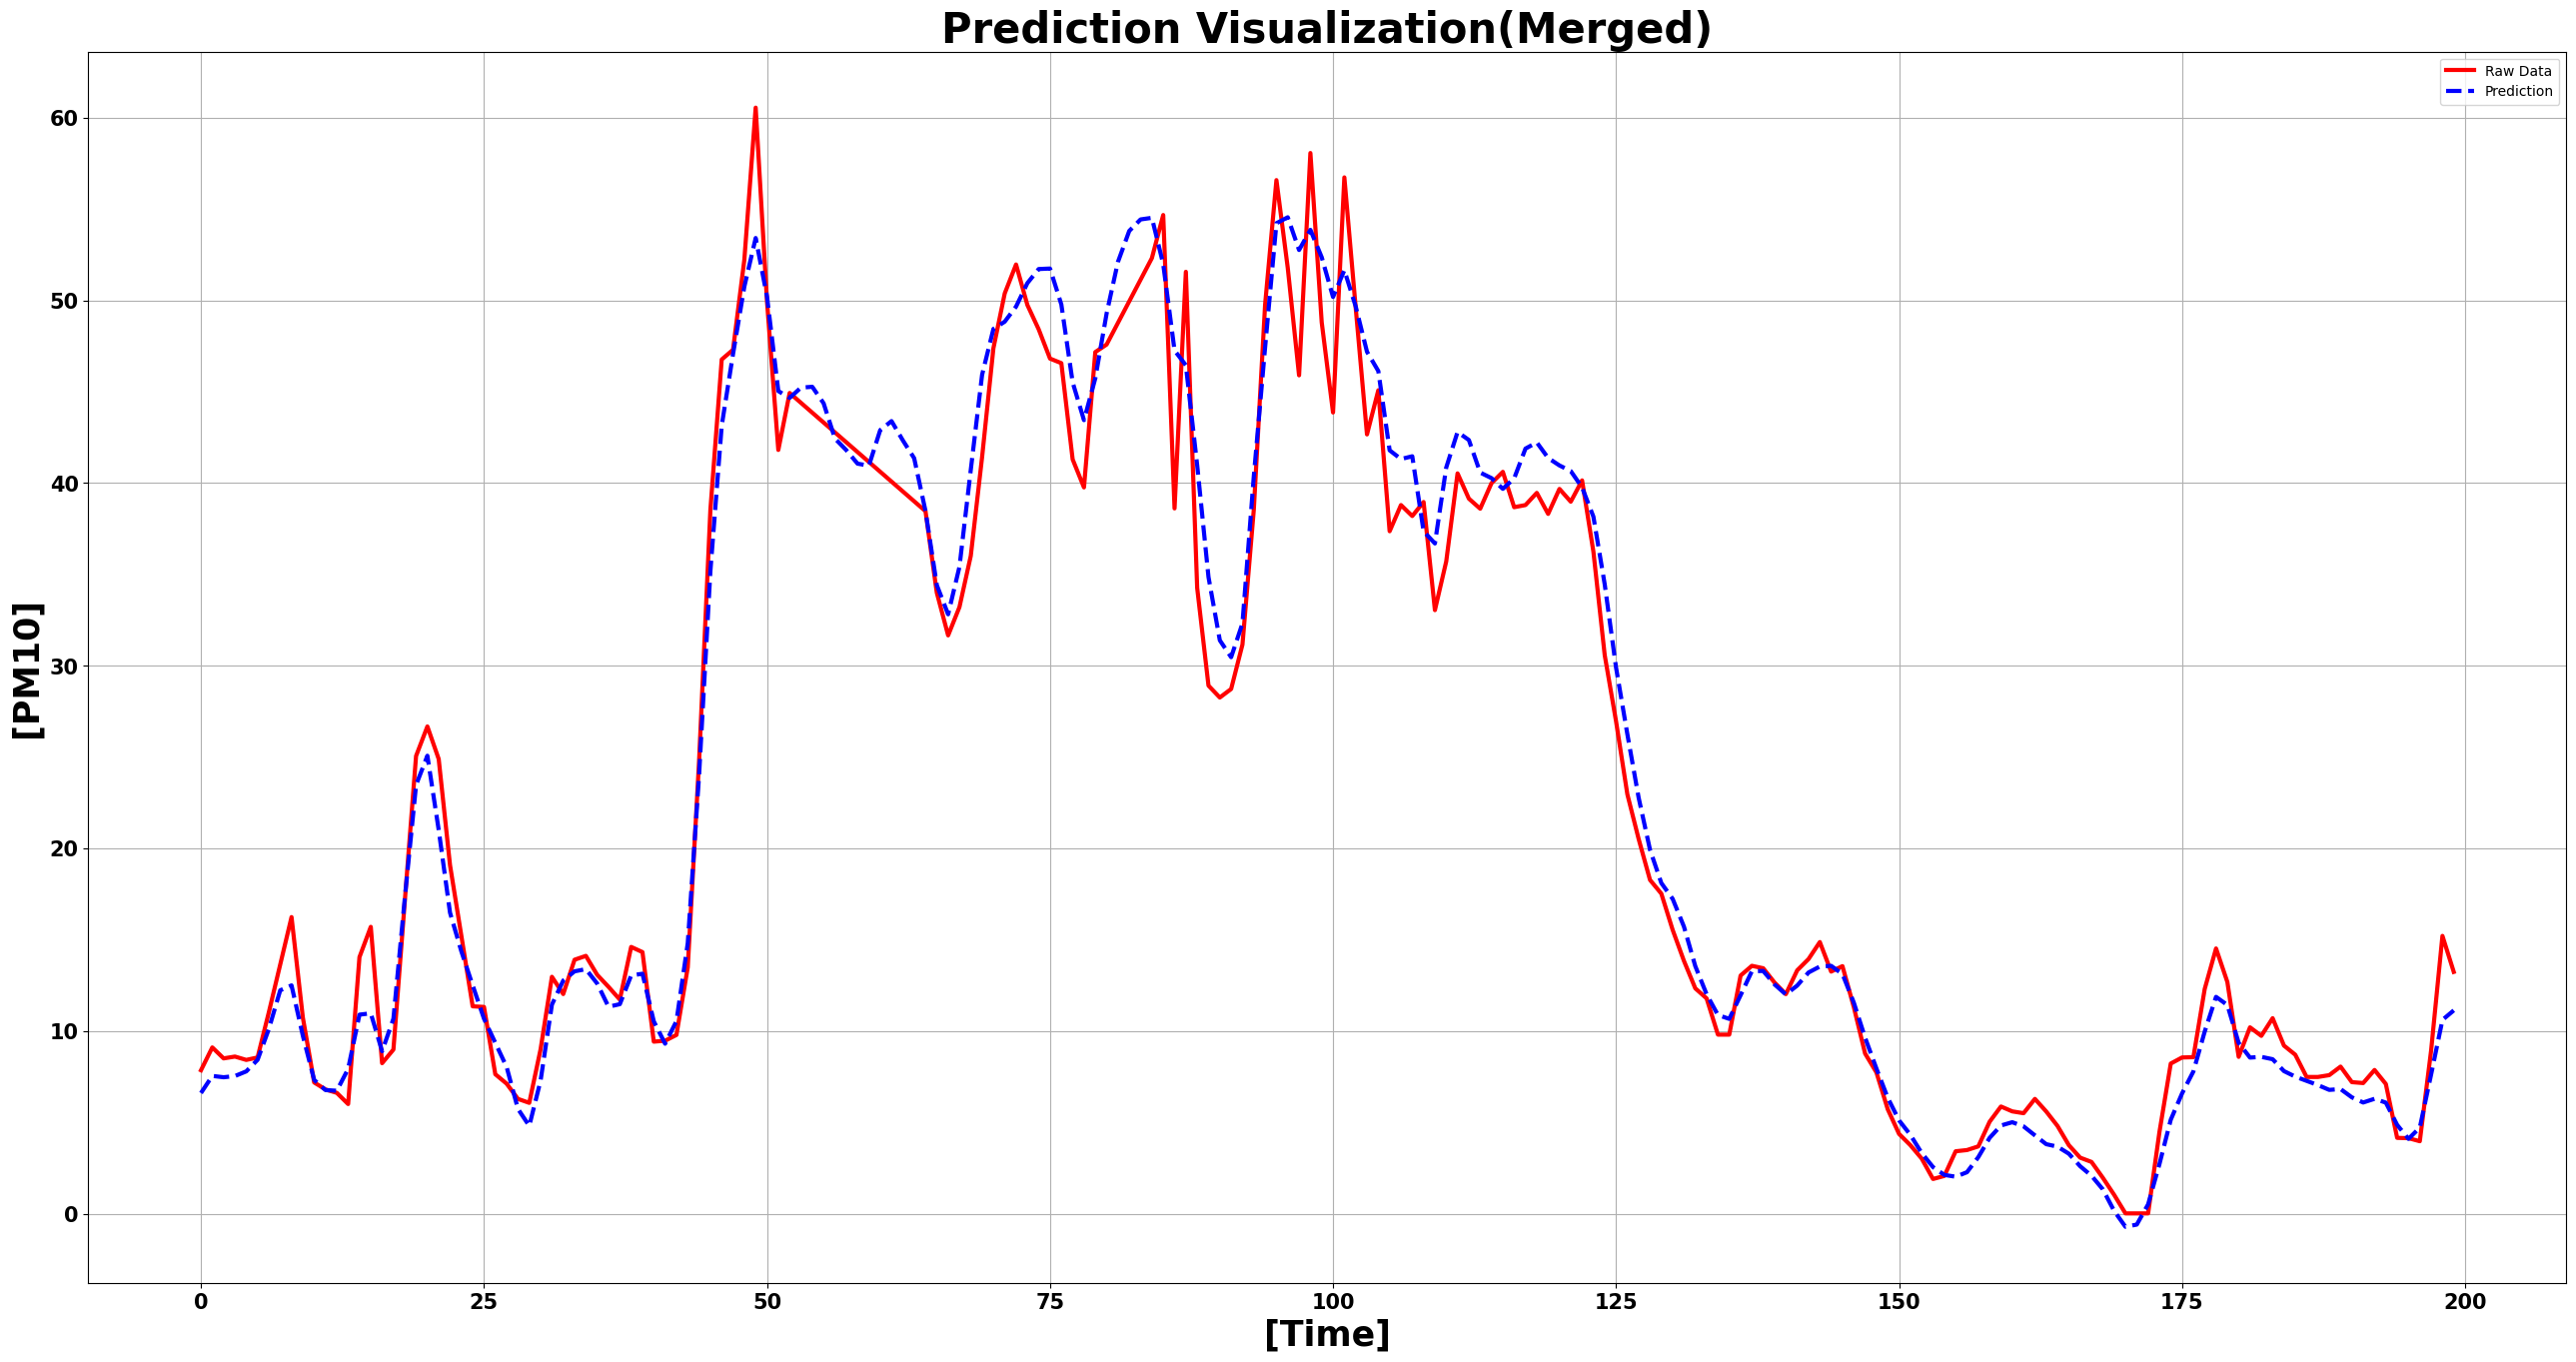

In [25]:
vizualization_self(200,'Merged',inv_test_y,inv_test_predict)